## Kumpulan Data Untuk di Proses

In [41]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("D:/Semester 6/tbd/cifar-10-python/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


Jumlah Data: Dataset ini terdiri dari 50.000 gambar, yang merupakan jumlah standar dari dataset CIFAR-10.

Ukuran Gambar: Gambar-gambar dalam dataset ini memiliki resolusi 32x32 piksel, yang merupakan ukuran standar untuk dataset CIFAR-10.

Channel Warna: Setiap gambar memiliki 3 channel warna: Merah (R), Hijau (G), dan Biru (B). Ini menunjukkan bahwa gambar-gambar dalam dataset ini berwarna (RGB), yang sesuai dengan dataset CIFAR-10.

Label: Setiap gambar memiliki label yang sesuai, yang masing-masing direpresentasikan oleh angka dalam array labels. Label ini mengidentifikasi kategori dari gambar tersebut (misalnya, mobil, pesawat, kucing, dsb.), tetapi informasi spesifik mengenai label-label tersebut tidak disertakan dalam output yang diberikan.

Secara keseluruhan, output ini mengkonfirmasi bahwa proses pemrosesan data telah berhasil dan dataset CIFAR-10 telah dimuat dengan benar, siap untuk digunakan dalam pelatihan atau analisis lebih lanjut.

In [42]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
pip install lmdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [46]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

In [47]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

In [48]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

In [50]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

In [51]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

In [52]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [53]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.042800100054591894
Method: lmdb, Time usage: 0.0029751998372375965
Method: hdf5, Time usage: 0.0036964998580515385


Dari hasil pengukuran waktu, metode "disk" menunjukkan kinerja yang paling lambat, sementara "lmdb" dan "hdf5" menunjukkan kinerja yang jauh lebih cepat. "lmdb" memiliki waktu penggunaan yang paling cepat di antara ketiganya, diikuti oleh "hdf5", dan terakhir adalah "disk". Ini menunjukkan bahwa untuk aplikasi yang memerlukan penyimpanan dan pengambilan data yang cepat, metode "lmdb" mungkin merupakan pilihan yang lebih baik dibandingkan dengan metode "disk" atau "hdf5".

In [54]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

In [55]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


Dataset CIFAR-10 awal yang terdiri dari 50.000 gambar dan label sekarang telah berhasil digandakan menjadi 100.000 gambar dan label. Proses penggandaan ini dapat bermanfaat untuk pelatihan model yang lebih baik dengan dataset yang lebih besar atau untuk tujuan validasi dan pengujian yang lebih lengkap. Namun, perlu diingat bahwa proses ini juga memerlukan lebih banyak memori dan sumber daya komputasi.

In [56]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.008389799855649471
Method: lmdb, Time usage: 0.0024121003225445747
Method: hdf5, Time usage: 0.0021763998083770275
Method: disk, Time usage: 0.07786960015073419
Method: lmdb, Time usage: 0.004879499785602093
Method: hdf5, Time usage: 0.0013009998947381973
Method: disk, Time usage: 0.4985676002688706
Method: lmdb, Time usage: 0.027817599941045046
Method: hdf5, Time usage: 0.0023207999765872955
Method: disk, Time usage: 5.424268499948084
Method: lmdb, Time usage: 0.26781760016456246
Method: hdf5, Time usage: 0.024119599722325802
Method: disk, Time usage: 46.76216259971261
Method: lmdb, Time usage: 3.5520147001370788
Method: hdf5, Time usage: 4.968029799871147


Berdasarkan hasil pengukuran waktu, metode "disk" cenderung memiliki kinerja yang lebih lambat dibandingkan dengan "lmdb" dan "hdf5", terutama saat menghadapi dataset yang lebih besar. Sementara itu, "lmdb" dan "hdf5" menunjukkan kinerja yang lebih cepat dan konsisten, dengan "lmdb" memiliki kinerja yang sedikit lebih baik dibandingkan "hdf5" dalam skenario ini. Oleh karena itu, untuk aplikasi yang memerlukan penyimpanan dan pengambilan data yang cepat, "lmdb" mungkin merupakan pilihan yang lebih baik dibandingkan dengan "disk" atau "hdf5".

C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_23820\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


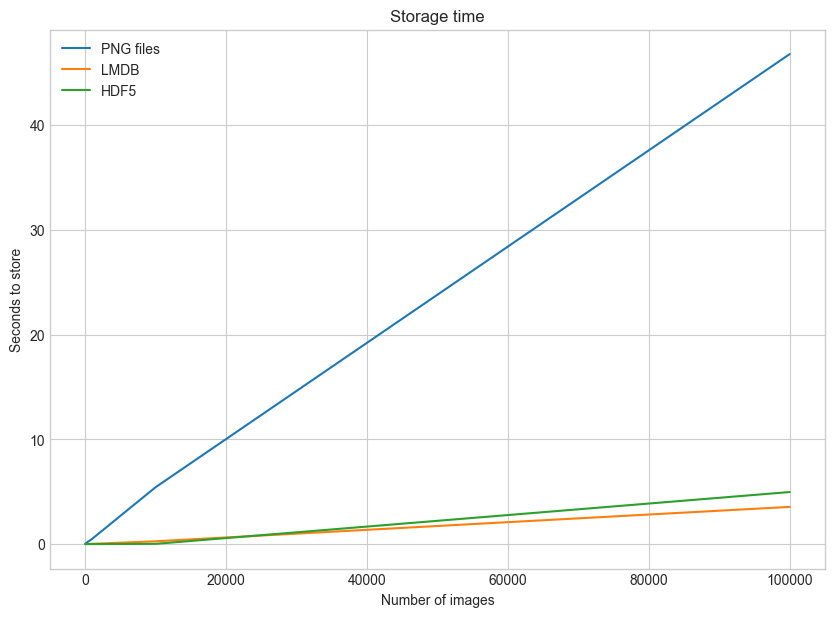

C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_23820\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


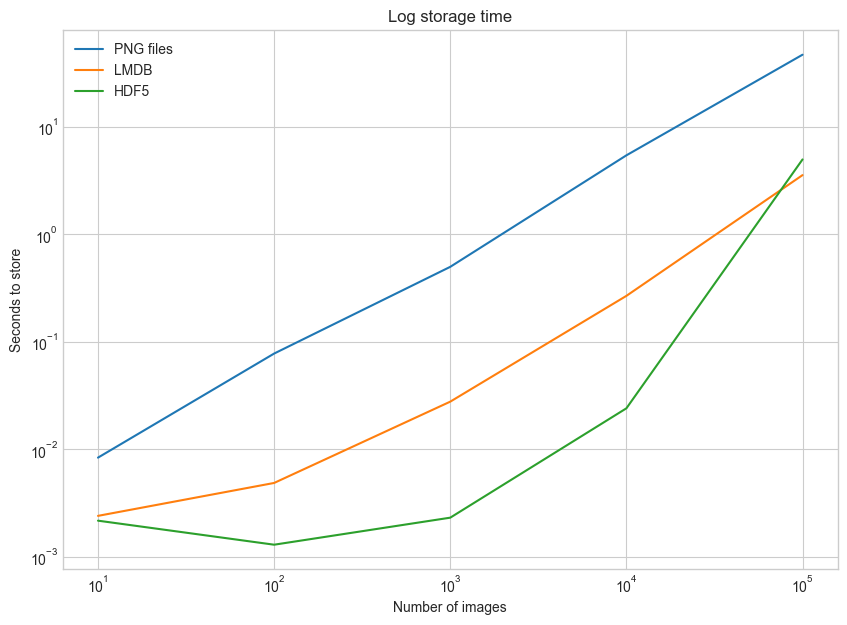

In [57]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

Sumbu X mewakili jumlah gambar, sedangkan sumbu Y mewakili waktu dalam detik yang dibutuhkan untuk menyimpan gambar tersebut. Ada tiga garis dalam grafik, masing-masing mewakili metode penyimpanan yang berbeda. Garis biru mewakili file PNG, garis hijau mewakili LMDB, dan garis oranye mewakili HDF5.

Dari grafik terlihat bahwa file PNG adalah metode paling lambat untuk menyimpan gambar, diikuti oleh HDF5 dan kemudian LMDB. Hal ini dikarenakan file PNG adalah format gambar yang tidak terkompresi, sedangkan LMDB dan HDF5 adalah format terkompresi.

In [58]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

In [59]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

In [60]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [61]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

In [62]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.013063500169664621
Method: lmdb, Time usage: 0.019996099639683962
Method: hdf5, Time usage: 0.010588299948722124


Berdasarkan hasil pengukuran waktu, metode "disk" menunjukkan kinerja yang paling cepat dalam operasi pembacaan data tunggal di antara ketiga metode yang diuji. Meskipun "lmdb" dan "hdf5" memiliki waktu pembacaan yang sedikit lebih lama dibandingkan dengan "disk", perbedaannya tidak terlalu signifikan. Oleh karena itu, untuk aplikasi yang memerlukan operasi pembacaan data yang cepat, "disk" mungkin merupakan pilihan yang baik. Namun, "lmdb" dan "hdf5" juga dapat menjadi pilihan yang baik tergantung pada kebutuhan spesifik aplikasi dan faktor lain seperti efisiensi penyimpanan dan manajemen data.

In [63]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

In [67]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

IndexError: list index out of range